# Calculating CCA coupled patterns on SST data using Spy4Cast and Xeofs

### We will be estudying ENSO variability and following the example of [Sparse PCA](https://xeofs.readthedocs.io/en/latest/content/user_guide/auto_examples/1single/plot_eof-smode.html) on Xeofs docs

We will be using the package [Xeofs](https://xeofs.readthedocs.io) so it has be installed on your environment

In [ ]:
!pip install xeofs

<div class="alert alert-block alert-info">
⚠️ Xeofs requires python version >= 3.10
</div>


# Data ingestion and preprocessing

In [54]:
from spy4cast import Dataset, Region, Month
from spy4cast.spy4cast import Preprocess
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import os

In [3]:
# We will use sea surface temperature both for dataset and predictor, but
# with differnt regions
predictor = Preprocess(Dataset("HadISST_sst_chopped.nc", "./datasets").open("sst").slice(
    Region(lat0=-30, latf=10,
           lon0=-60, lonf=15,
           month0=Month.JUN, monthf=Month.AUG,
           year0=1970, yearf=2019),
))
predictand = Preprocess(Dataset("HadISST_sst_chopped.nc", "./datasets").open("sst").slice(
    Region(lat0=-30, latf=30,
           lon0=-200, lonf=-60,
           month0=Month.DEC, monthf=Month.FEB,  
           # year0, yearf refer to monthf -> will span from DEC 1970 to FEB 2020 
           year0=1971, yearf=2020),
))

[INFO] Preprocessing data for variable sst took: 0.073 seconds
[INFO] Preprocessing data for variable sst took: 0.468 seconds


## Create single variable out of Y and Z

We have to matrices, one $Y \rightarrow (n_y \times n_t)$ and one $Z \rightarrow (n_z \times n_t)$.

By concatenating the along the $0$ axis we have one $X \rightarrow ((n_y + n_z) \times n_t)$

In [4]:
y = predictor.data
y.shape

(3000, 50)

In [5]:
z = predictand.data
z.shape

(8400, 50)

In [6]:
x = np.concatenate([y, z])
# Check that the first ny rows are Y and the next nz rows are Z
ny, nz = y.shape[0], z.shape[0]
assert (np.isclose(x[:ny, :], y) | np.isnan(y)).all()
assert (np.isclose(x[ny:, :], z) | np.isnan(z)).all()
x.shape

(11400, 50)

In [7]:
sst = xr.DataArray(
    x, dims=("space", "time"), coords={"time": predictor.time.values}
)
sst

<xarray.DataArray (space: 11400, time: 50)> Size: 2MB
array([[ 0.1218338 , -0.7404156 , -0.37068748, ...,  0.40730476,
        -0.08609772,  0.7360344 ],
       [ 0.12066078, -0.6983509 , -0.50611687, ...,  0.43603134,
        -0.10463333,  0.71489143],
       [ 0.09488487, -0.60853004, -0.47955322, ...,  0.4428997 ,
        -0.08998299,  0.6097183 ],
       ...,
       [-0.04133224, -0.6569271 ,  0.27676392, ...,  0.3637085 ,
         0.08168983,  0.23239326],
       [ 0.08904076, -0.6933708 ,  0.30057144, ...,  0.29126167,
         0.05827522,  0.31897163],
       [ 0.1316433 , -0.65839577,  0.30573654, ...,  0.24592209,
         0.0136776 ,  0.355505  ]], dtype=float32)
Coordinates:
  * time     (time) int64 400B 1970 1971 1972 1973 1974 ... 2016 2017 2018 2019
Dimensions without coordinates: space

## Sparse PCA

In [8]:
import xeofs as xe

In [9]:
model = xe.single.SparsePCA(n_modes=4, alpha=1e-5)
model.fit(sst, dim="time")

In [10]:
expvar = model.explained_variance()
expvar_ratio = model.explained_variance_ratio()
components = model.components()
scores = model.scores()

In [11]:
print("Explained variance: ", expvar.round(0).values)
print("Relative: ", (expvar_ratio * 100).round(1).values)

Explained variance:  [1790.  354.  227.  154.]
Relative:  [54.4 10.8  6.9  4.7]


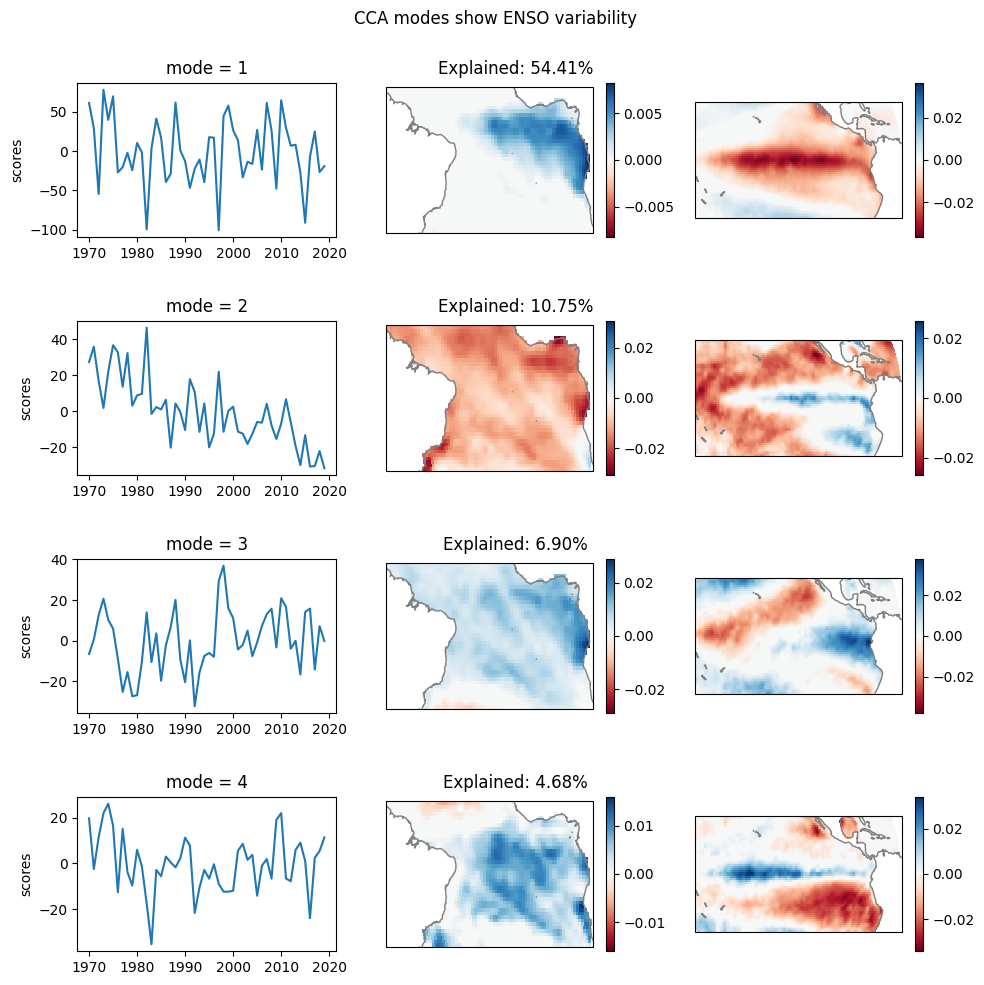

In [59]:
kwargs = {"cmap": "RdBu", "vmin": None, "vmax": None, "transform": ccrs.PlateCarree()}

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 3, width_ratios=[1, 1, 1])
ax0 = [fig.add_subplot(gs[i, 0]) for i in range(4)]
ax1 = [fig.add_subplot(gs[i, 1], projection=ccrs.EqualEarth(central_longitude=0)) for i in range(4)]
ax2 = [fig.add_subplot(gs[i, 2], projection=ccrs.EqualEarth(central_longitude=180)) for i in range(4)]

for i, (a0, a1, a2) in enumerate(zip(ax0, ax1, ax2)):
    x_i = components.sel(mode=i+1)
    y_i = xr.DataArray(
        x_i.isel(space=slice(0, ny)).values.reshape(predictor.lat.shape[0], predictor.lon.shape[0]),
        dims=("lat", "lon"),
        coords={"lat": predictor.lat.values, "lon": predictor.lon.values},
    )
    z_i = xr.DataArray(
        x_i.isel(space=slice(ny, None)).values.reshape(predictand.lat.shape[0], predictand.lon.shape[0]),
        dims=("lat", "lon"),
        coords={
            "lat": predictand.lat.values, 
            "lon": np.where(predictand.lon.values < 0, predictand.lon.values + 360, predictand.lon.values)
        },
    ).sortby("lon")
    
    scores.sel(mode=i + 1).plot(ax=a0)
    #print(z_i.lon.min()+360, z_i.lon.max())
    
    ax_title = fig.add_subplot(gs[i, :])
    ax_title.axis('off')
    ax_title.set_title(f'Explained: {expvar_ratio.values[i]*100:.02f}%')
    
    a1.coastlines(color=".5")
    y_i.plot(ax=a1, **kwargs)
    
    a2.coastlines(color=".5")
    z_i.plot(ax=a2, **kwargs)

    a0.set_xlabel("")
    
fig.suptitle("CCA modes show ENSO variability")

plt.tight_layout()

PLOTS_DIR = "plots-CCA_using_XEOFS"
if not os.path.exists(PLOTS_DIR):
    os.makedirs(PLOTS_DIR)

plt.savefig(os.path.join(PLOTS_DIR, "sparse_pca.png"))

#### 